In [1]:
from tqdm import tqdm
from skimage.transform import resize 

In [2]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
from keras_applications.vgg16 import VGG16

In [5]:
from keras import Sequential
from keras.layers import (BatchNormalization, Conv2D,
                          MaxPooling2D, Activation, Dropout,
                         Dense, Flatten)
from keras.optimizers import Adam, RMSprop

In [6]:
# data path
data_path = 'data'

In [7]:
# all classes - Closed Open Partially Closed
classes = os.listdir(data_path)

In [8]:
class_sizes = [len(os.listdir(os.path.join(data_path ,classes[i])))
               for i in range(len(classes))]

Text(0.5, 1.0, 'Class Distribution')

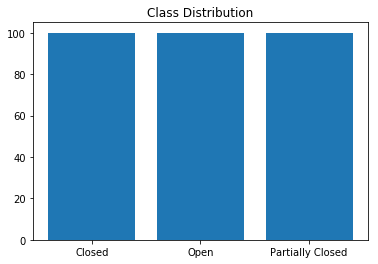

In [9]:
plt.bar(range(1,4), class_sizes)
plt.xticks(range(1,4), classes)
plt.title('Class Distribution')

In [10]:
class Config(object):
    
    def __init__(self):
        
        self.min_width = 35000
        self.min_height = 35000
        self.max_width = 0
        self.max_height = 0

In [11]:
config = Config() # config object

In [12]:
# check image size
def get_all_file_paths(path=data_path):
    
    files = []
    # walk through all files
    for root, dirs, file in os.walk(data_path):
        for f in file:
            files.append(os.path.join(root, f))
            
    return files

In [14]:
img_rows = 100
img_cols = 150
img_channels = 1
target_size = [img_rows, img_cols]

In [15]:
def get_images(padding=True, desired_shape='max', target_size=target_size):
    
    all_images = []
    labels = []
    files = get_all_file_paths() # all file paths
    
    for file in tqdm(files):

        # read image
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        file_shape = img.shape

        ht = file_shape[0]
        wd = file_shape[1]
        
        if padding:
            if ht > config.max_height:
                config.max_height = ht

            if wd > config.max_width:
                config.max_width = wd

            if ht < config.min_height:
                config.min_height = ht

            if wd < config.min_width:
                config.min_width = wd

            if desired_shape == 'max':
                desired_shape=(config.max_height, config.max_width)

            # calculating pad length
            ht_diff = desired_shape[0] - ht
            ht_up = ht_diff//2
            ht_down = ht_diff - ht_up

            wd_diff = desired_shape[1] - wd
            wd_left = wd_diff//2
            wd_right = wd_diff - wd_left
            

            # padding image
            img = np.pad(img,
                        ((ht_up, ht_down),
                         (wd_left, wd_right)),
                            mode='constant').reshape(desired_shape[0], desired_shape[1], 1)
            
            # resize image
            img = resize(img, target_size,
                         anti_aliasing=True)
            
            # appending image            
            all_images.append(img)
            
        else:
            # resize image
            img = resize(img, target_size,
                         anti_aliasing=True).reshape(target_size[0], target_size[1], 1)
            
            all_images.append(img)
        
        # appending label
        labels.append(file.split('\\')[1])
    
    return np.array(all_images), labels

In [16]:
all_images, labels = get_images(padding=False)

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]D:\anaconda\envs\deep-work\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 150.13it/s]


In [17]:
print('MAX height-width:', (config.max_height, config.max_width))
print('MIN height-width:', (config.min_height, config.min_width))

MAX height-width: (0, 0)
MIN height-width: (35000, 35000)


In [18]:
all_images[0].shape

(100, 150, 1)

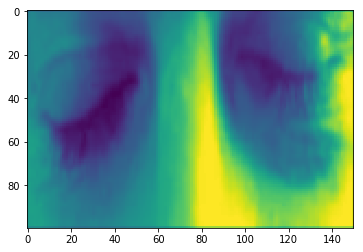

In [19]:
plt.imshow(all_images[0].reshape(img_rows, img_cols))

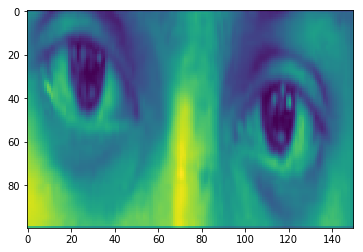

In [20]:
plt.imshow(all_images[152].reshape(img_rows, img_cols))

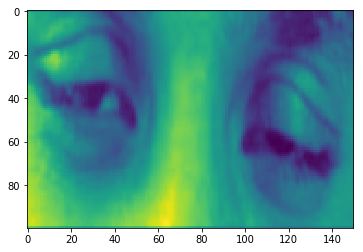

In [21]:
plt.imshow(all_images[260].reshape(img_rows, img_cols))

In [22]:
# encoding labels
enc = LabelBinarizer()
y = enc.fit_transform(labels)

In [23]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.3
)

In [24]:
train_gen = train_datagen.flow(all_images, y, subset='training', batch_size=8) # training
valid_gen = train_datagen.flow(all_images, y, subset='validation', batch_size=4) # validation

In [25]:
target_size

[100, 150]

In [30]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=(img_rows, img_cols, img_channels)))
model.add(Conv2D(64, (3,3)))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3)))
model.add(Conv2D(128, (3,3)))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3,3)))
model.add(Conv2D(256, (3,3)))
model.add(Conv2D(256, (3,3)))
model.add(MaxPooling2D())

model.add(Conv2D(512, (3,3)))
model.add(Conv2D(512, (3,3)))
model.add(Conv2D(512, (3,3)))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
print(STEP_SIZE_TRAIN)

26


In [32]:
STEP_SIZE_VALIDATE = valid_gen.n // valid_gen.batch_size
print(STEP_SIZE_VALIDATE)

22


In [33]:
model.fit_generator(train_gen, steps_per_epoch=STEP_SIZE_TRAIN, epochs=15, verbose=1,
                    validation_data=valid_gen, validation_steps=STEP_SIZE_VALIDATE)

Epoch 1/15
26/26 [==============================] - ETA: 45s - loss: 1.0987 - acc: 0.0000e+ - ETA: 22s - loss: 1.0989 - acc: 0.0625   - ETA: 15s - loss: 1.1154 - acc: 0.08 - ETA: 11s - loss: 1.0687 - acc: 0.18 - ETA: 8s - loss: 3.2724 - acc: 0.2000 - ETA: 7s - loss: 2.8975 - acc: 0.250 - ETA: 6s - loss: 2.6627 - acc: 0.250 - ETA: 5s - loss: 2.4427 - acc: 0.281 - ETA: 4s - loss: 2.2669 - acc: 0.333 - ETA: 4s - loss: 2.1020 - acc: 0.350 - ETA: 3s - loss: 2.1770 - acc: 0.352 - ETA: 3s - loss: 2.0516 - acc: 0.354 - ETA: 2s - loss: 2.2364 - acc: 0.346 - ETA: 2s - loss: 2.1924 - acc: 0.348 - ETA: 2s - loss: 2.3543 - acc: 0.333 - ETA: 1s - loss: 2.4601 - acc: 0.343 - ETA: 1s - loss: 2.3914 - acc: 0.345 - ETA: 1s - loss: 2.4148 - acc: 0.333 - ETA: 1s - loss: 2.6690 - acc: 0.328 - ETA: 0s - loss: 2.9386 - acc: 0.337 - ETA: 0s - loss: 3.5662 - acc: 0.321 - ETA: 0s - loss: 3.7704 - acc: 0.329 - ETA: 0s - loss: 3.9568 - acc: 0.337 - ETA: 0s - loss: 4.1278 - acc: 0.343 - ETA: 0s - loss: 4.2850 - ac

26/26 [==============================] - ETA: 1s - loss: 10.0738 - acc: 0.37 - ETA: 1s - loss: 10.0738 - acc: 0.37 - ETA: 1s - loss: 8.7306 - acc: 0.4583 - ETA: 1s - loss: 8.0590 - acc: 0.500 - ETA: 1s - loss: 8.0590 - acc: 0.500 - ETA: 1s - loss: 7.7233 - acc: 0.520 - ETA: 1s - loss: 7.1956 - acc: 0.553 - ETA: 1s - loss: 7.3035 - acc: 0.546 - ETA: 1s - loss: 7.1636 - acc: 0.555 - ETA: 1s - loss: 7.4546 - acc: 0.537 - ETA: 1s - loss: 7.5096 - acc: 0.534 - ETA: 1s - loss: 7.5554 - acc: 0.531 - ETA: 1s - loss: 7.5941 - acc: 0.528 - ETA: 0s - loss: 7.9151 - acc: 0.508 - ETA: 0s - loss: 8.0590 - acc: 0.500 - ETA: 0s - loss: 8.0590 - acc: 0.500 - ETA: 0s - loss: 7.8220 - acc: 0.514 - ETA: 0s - loss: 7.8352 - acc: 0.513 - ETA: 0s - loss: 7.7409 - acc: 0.519 - ETA: 0s - loss: 7.8576 - acc: 0.512 - ETA: 0s - loss: 7.8672 - acc: 0.511 - ETA: 0s - loss: 7.8759 - acc: 0.511 - ETA: 0s - loss: 7.8839 - acc: 0.510 - ETA: 0s - loss: 7.9751 - acc: 0.505 - ETA: 0s - loss: 8.0590 - acc: 0.500 - 2s 89ms/

26/26 [==============================] - ETA: 1s - loss: 4.0295 - acc: 0.750 - ETA: 1s - loss: 6.0443 - acc: 0.625 - ETA: 1s - loss: 6.7159 - acc: 0.583 - ETA: 1s - loss: 7.0517 - acc: 0.562 - ETA: 1s - loss: 7.2531 - acc: 0.550 - ETA: 1s - loss: 7.7233 - acc: 0.520 - ETA: 1s - loss: 7.1956 - acc: 0.553 - ETA: 1s - loss: 7.5554 - acc: 0.531 - ETA: 1s - loss: 7.6113 - acc: 0.527 - ETA: 1s - loss: 7.2531 - acc: 0.550 - ETA: 1s - loss: 7.5096 - acc: 0.534 - ETA: 1s - loss: 7.2196 - acc: 0.552 - ETA: 1s - loss: 7.5941 - acc: 0.528 - ETA: 0s - loss: 7.7712 - acc: 0.517 - ETA: 0s - loss: 7.6561 - acc: 0.525 - ETA: 0s - loss: 7.3035 - acc: 0.546 - ETA: 0s - loss: 7.4665 - acc: 0.536 - ETA: 0s - loss: 7.4994 - acc: 0.534 - ETA: 0s - loss: 7.3168 - acc: 0.546 - ETA: 0s - loss: 7.4546 - acc: 0.537 - ETA: 0s - loss: 7.6753 - acc: 0.523 - ETA: 0s - loss: 7.7843 - acc: 0.517 - ETA: 0s - loss: 7.8839 - acc: 0.510 - ETA: 0s - loss: 7.8912 - acc: 0.510 - ETA: 0s - loss: 8.1396 - acc: 0.495 - 2s 89ms/s

In [ ]:
model.